<a href="https://colab.research.google.com/github/sidusit/MTech-Dissertation/blob/main/DL_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [ ]:
TCS = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Database/Indian/MARUTI_PreProcessed.csv")
HDFC = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Database/Indian/HDFC_PreProcessed.csv")
HUL = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Database/Indian/HUL_PreProcessed.csv")
MARUTI = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Database/Indian/MARUTI_PreProcessed.csv")

### Data Proprocessing

In [ ]:
def Dataset(Data, date):

  Train_Data = Data['adj close'][Data['date'] < date].to_numpy()
  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []
  for i in range(0, len(Train_Data), 5):
    try:
      Data_Train.append(Train_Data[i : i + 5])
    except:
      pass

  if len(Data_Train[-1]) < 5:
    Data_Train.pop(-1)
  
  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, 5, 1))
  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))


  Test_Data = Data['adj close'][Data['date'] >= date].to_numpy()
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []
  for i in range(0, len(Test_Data), 5):
    try:
      Data_Test.append(Test_Data[i : i + 5])
    except:
      pass

  if len(Data_Test[-1]) < 5:
    Data_Test.pop(-1)
  
  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, 5, 1))
  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, 5, 1))

  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

### Model

In [ ]:
def Model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return model

In [ ]:
model = Model()

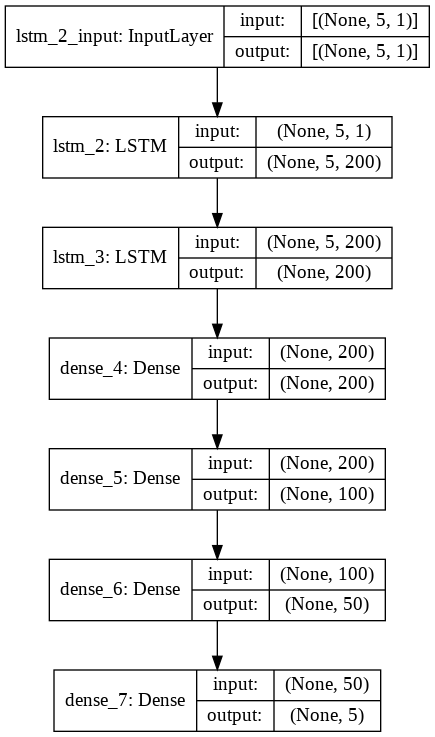

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 200)            161600    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 255       
Total params: 548,005
Trainable params: 548,005
Non-trainable params: 0
________________________________________________

### Custom Learning Rate

In [ ]:
def scheduler(epoch):
  
  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150) 
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)
  
  return lrate

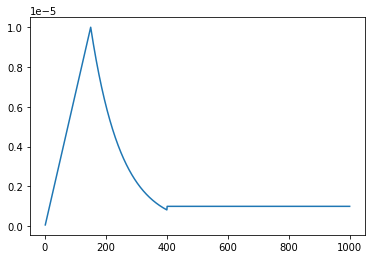

In [ ]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#TCS

In [ ]:
TCS.tail()

,ticker,date,open,high,low,close,adj close,volume,Moving Average for 10 days,Moving Average for 20 days,Moving Average for 50 days,Daily Return
692,TCS.NS,2021-10-25,3503.00,3514.55,3450.0,3492.95,3492.95,2594211.0,3599.849,3704.2600,3719.0880,-0.001686
693,TCS.NS,2021-10-26,3494.50,3529.00,3475.0,3482.60,3482.60,3877980.0,3580.255,3686.9100,3721.8334,-0.002963
694,TCS.NS,2021-10-27,3483.00,3511.25,3483.0,3489.75,3489.75,2509919.0,3564.645,3672.8020,3722.4930,0.002053
695,TCS.NS,2021-10-28,3518.00,3518.00,3415.0,3421.65,3421.65,2423261.0,3541.990,3654.6525,3721.6000,-0.019514
696,TCS.NS,2021-10-29,3400.05,3453.75,3395.5,3434.40,3434.40,1390025.0,3524.285,3637.9565,3719.3630,0.003726


In [ ]:
TCS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ticker                      697 non-null    object 
 1   date                        697 non-null    object 
 2   open                        697 non-null    float64
 3   high                        697 non-null    float64
 4   low                         697 non-null    float64
 5   close                       697 non-null    float64
 6   adj close                   697 non-null    float64
 7   volume                      697 non-null    float64
 8   Moving Average for 10 days  688 non-null    float64
 9   Moving Average for 20 days  678 non-null    float64
 10  Moving Average for 50 days  648 non-null    float64
 11  Daily Return                696 non-null    float64
dtypes: float64(10), object(2)
memory usage: 65.5+ KB


In [ ]:
# Change Dtype of date column
TCS["date"] = pd.to_datetime(TCS["date"])

###Split the Data into Training and Test set
    Training Period: 2019-01-01 - 2021-08-01

    Testing Period:  2021-08-01 - 2021-10-29

In [ ]:
TCS_date = '2021-08-01'
TCS_Train_X, TCS_Train_Y, TCS_Test_X, TCS_Test_Y = Dataset(TCS, TCS_date)

In [ ]:
TCS_Train_X.shape, TCS_Train_Y.shape, TCS_Test_X.shape, TCS_Test_Y.shape

((126, 5, 1), (126, 5, 1), (11, 5, 1), (11, 5, 1))

In [ ]:
# TCS['adj close'].tail(20)

In [ ]:
# TCS_Test_X[-1], TCS_Test_Y[-1]

### Model Fitting

In [ ]:
TCS_Model = Model()

In [ ]:
TCS_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
TCS_hist = TCS_Model.fit(TCS_Train_X, TCS_Train_Y, epochs = 1000, validation_data = (TCS_Test_X, TCS_Test_Y), callbacks=[callback])

Epoch 1/1000
4/4 [==============================] - 0s 43ms/step - loss: 4731824.5000 - root_mean_squared_error: 2175.2756 - val_loss: 11203083.0000 - val_root_mean_squared_error: 3347.1006
Epoch 2/1000
4/4 [==============================] - 0s 36ms/step - loss: 4731718.5000 - root_mean_squared_error: 2175.2515 - val_loss: 11202396.0000 - val_root_mean_squared_error: 3346.9978
Epoch 3/1000
4/4 [==============================] - 0s 34ms/step - loss: 4731324.0000 - root_mean_squared_error: 2175.1606 - val_loss: 11200987.0000 - val_root_mean_squared_error: 3346.7876
Epoch 4/1000
4/4 [==============================] - 0s 38ms/step - loss: 4730638.0000 - root_mean_squared_error: 2175.0032 - val_loss: 11198907.0000 - val_root_mean_squared_error: 3346.4768
Epoch 5/1000
4/4 [==============================] - 0s 38ms/step - loss: 4729651.0000 - root_mean_squared_error: 2174.7761 - val_loss: 11196178.0000 - val_root_mean_squared_error: 3346.0691
Epoch 6/1000
4/4 [==============================] 

In [ ]:
history_dict = TCS_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

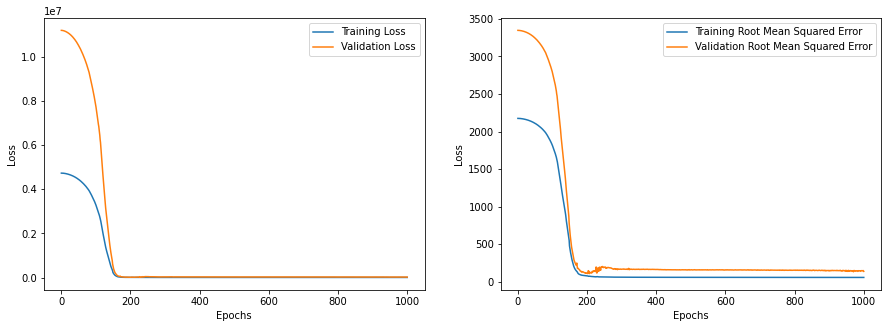

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Apple

In [ ]:
TCS_prediction = TCS_Model.predict(TCS_Test_X)

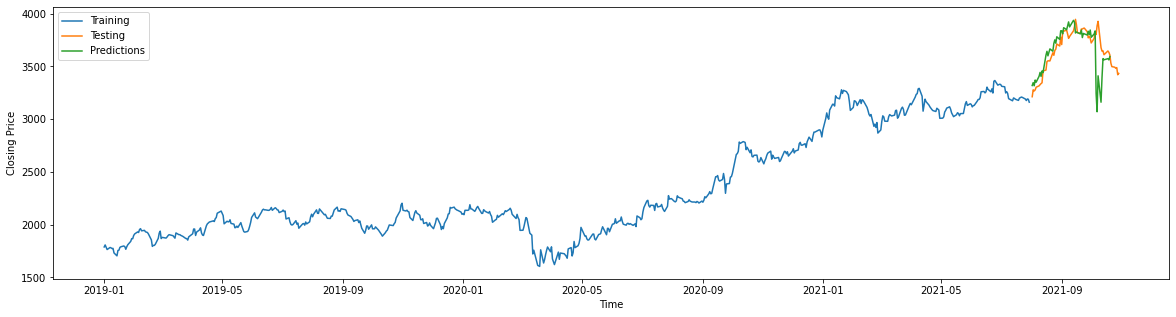

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(TCS['date'][TCS['date'] < '2021-08-01'], TCS['adj close'][TCS['date'] < '2021-08-01'], label = 'Training')
plt.plot(TCS['date'][TCS['date'] >= '2021-08-01'], TCS['adj close'][TCS['date'] >= '2021-08-01'], label = 'Testing')
plt.plot(TCS['date'][TCS['date'] >= '2021-08-01'][:-7], TCS_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [ ]:
rmse = math.sqrt(mean_squared_error(TCS_Test_Y.reshape(-1, 5), TCS_prediction))
mape = np.mean(np.abs(TCS_prediction - TCS_Test_Y.reshape(-1, 5))/np.abs(TCS_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 139.83249881556875
MAPE: 0.02459668510495865


#HDFC

In [ ]:
HDFC.tail()

,ticker,date,open,high,low,close,adj close,volume,Moving Average for 10 days,Moving Average for 20 days,Moving Average for 50 days,Daily Return
692,HDFC.NS,2021-10-25,2905.00,2919.0,2856.25,2896.15,2896.15,3463033.0,2815.240,2783.7400,2772.205,-0.002686
693,HDFC.NS,2021-10-26,2908.00,2934.0,2896.00,2911.65,2911.65,2429951.0,2831.480,2787.3325,2777.063,0.005352
694,HDFC.NS,2021-10-27,2920.05,2948.0,2901.40,2915.00,2915.00,3136162.0,2847.470,2792.8350,2781.280,0.001151
695,HDFC.NS,2021-10-28,2891.00,2924.3,2863.15,2900.80,2900.80,3302501.0,2860.990,2800.5525,2784.673,-0.004871
696,HDFC.NS,2021-10-29,2891.00,2893.0,2791.20,2844.70,2844.70,3829786.0,2864.585,2805.0725,2786.799,-0.019339


In [ ]:
HDFC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ticker                      697 non-null    object 
 1   date                        697 non-null    object 
 2   open                        697 non-null    float64
 3   high                        697 non-null    float64
 4   low                         697 non-null    float64
 5   close                       697 non-null    float64
 6   adj close                   697 non-null    float64
 7   volume                      697 non-null    float64
 8   Moving Average for 10 days  688 non-null    float64
 9   Moving Average for 20 days  678 non-null    float64
 10  Moving Average for 50 days  648 non-null    float64
 11  Daily Return                696 non-null    float64
dtypes: float64(10), object(2)
memory usage: 65.5+ KB


In [ ]:
# Change Dtype of date column
HDFC["date"] = pd.to_datetime(HDFC["date"])

###Split the Data into Training and Test set
    Training Period: 2019-01-01 - 2021-08-01

    Testing Period:  2021-08-01 - 2021-10-29

In [ ]:
HDFC_date = '2021-08-01'
HDFC_Train_X, HDFC_Train_Y, HDFC_Test_X, HDFC_Test_Y = Dataset(HDFC, HDFC_date)

In [ ]:
HDFC_Train_X.shape, HDFC_Train_Y.shape, HDFC_Test_X.shape, HDFC_Test_Y.shape

((126, 5, 1), (126, 5, 1), (11, 5, 1), (11, 5, 1))

In [ ]:
# HDFC['adj close'].tail(20)

In [ ]:
# HDFC_Test_X[-1], HDFC_Test_Y[-1]

### Model Fitting

In [ ]:
HDFC_Model = Model()

In [ ]:
HDFC_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
HDFC_hist = HDFC_Model.fit(HDFC_Train_X, HDFC_Train_Y, epochs = 1000, validation_data = (HDFC_Test_X, HDFC_Test_Y), callbacks=[callback])

Epoch 1/1000
4/4 [==============================] - 2s 137ms/step - loss: 4502550.5000 - root_mean_squared_error: 2121.9216 - val_loss: 7636456.5000 - val_root_mean_squared_error: 2763.4141
Epoch 2/1000
4/4 [==============================] - 0s 34ms/step - loss: 4502537.0000 - root_mean_squared_error: 2121.9185 - val_loss: 7636401.5000 - val_root_mean_squared_error: 2763.4038
Epoch 3/1000
4/4 [==============================] - 0s 39ms/step - loss: 4502491.5000 - root_mean_squared_error: 2121.9077 - val_loss: 7636296.5000 - val_root_mean_squared_error: 2763.3853
Epoch 4/1000
4/4 [==============================] - 0s 35ms/step - loss: 4502400.0000 - root_mean_squared_error: 2121.8860 - val_loss: 7636102.0000 - val_root_mean_squared_error: 2763.3499
Epoch 5/1000
4/4 [==============================] - 0s 35ms/step - loss: 4502279.0000 - root_mean_squared_error: 2121.8577 - val_loss: 7635861.0000 - val_root_mean_squared_error: 2763.3062
Epoch 6/1000
4/4 [==============================] - 0s

In [ ]:
history_dict = HDFC_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

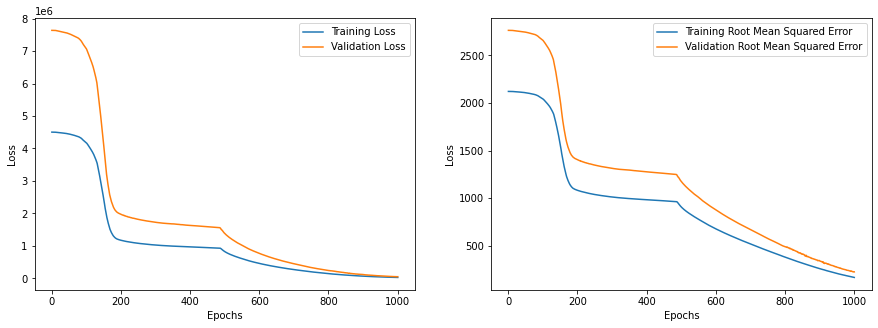

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of HDFC

In [ ]:
HDFC_prediction = HDFC_Model.predict(HDFC_Test_X)

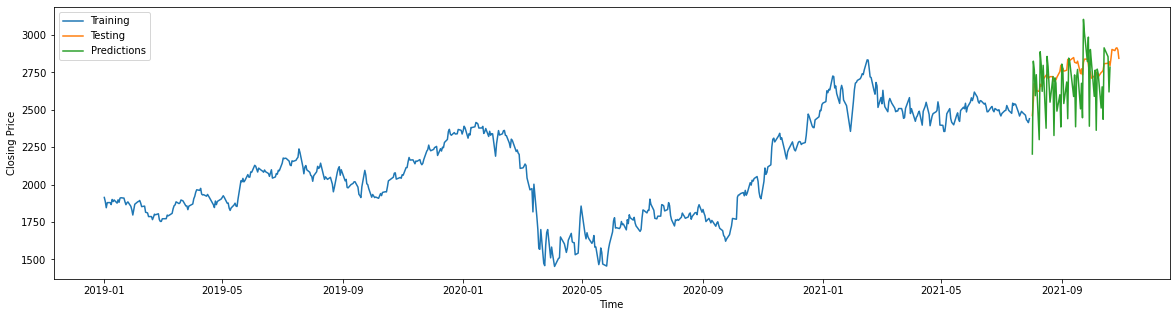

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(HDFC['date'][HDFC['date'] < '2021-08-01'], HDFC['adj close'][HDFC['date'] < '2021-08-01'], label = 'Training')
plt.plot(HDFC['date'][HDFC['date'] >= '2021-08-01'], HDFC['adj close'][HDFC['date'] >= '2021-08-01'], label = 'Testing')
plt.plot(HDFC['date'][HDFC['date'] >= '2021-08-01'][:-7], HDFC_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [ ]:
rmse = math.sqrt(mean_squared_error(HDFC_Test_Y.reshape(-1, 5), HDFC_prediction))
mape = np.mean(np.abs(HDFC_prediction - HDFC_Test_Y.reshape(-1, 5))/np.abs(HDFC_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 226.14718856963287
MAPE: 0.0652410028230787


#HUL

In [ ]:
HUL.tail()

,ticker,date,open,high,low,close,adj close,volume,Moving Average for 10 days,Moving Average for 20 days,Moving Average for 50 days,Daily Return
692,HINDUNILVR.NS,2021-10-25,2454.1,2463.55,2410.00,2455.85,2455.85,1560090.0,2565.270,2628.3775,2665.198,0.000713
693,HINDUNILVR.NS,2021-10-26,2468.9,2468.90,2417.05,2436.85,2436.85,1594662.0,2544.445,2614.7450,2666.089,-0.007737
694,HINDUNILVR.NS,2021-10-27,2455.0,2455.20,2391.15,2396.60,2396.60,3082296.0,2516.490,2598.3825,2665.931,-0.016517
695,HINDUNILVR.NS,2021-10-28,2400.0,2416.00,2368.00,2389.65,2389.65,2014755.0,2490.780,2583.6000,2665.196,-0.002900
696,HINDUNILVR.NS,2021-10-29,2400.0,2400.00,2376.00,2383.60,2383.60,847292.0,2464.185,2567.6900,2663.192,-0.002532


In [ ]:
HUL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ticker                      697 non-null    object 
 1   date                        697 non-null    object 
 2   open                        697 non-null    float64
 3   high                        697 non-null    float64
 4   low                         697 non-null    float64
 5   close                       697 non-null    float64
 6   adj close                   697 non-null    float64
 7   volume                      697 non-null    float64
 8   Moving Average for 10 days  688 non-null    float64
 9   Moving Average for 20 days  678 non-null    float64
 10  Moving Average for 50 days  648 non-null    float64
 11  Daily Return                696 non-null    float64
dtypes: float64(10), object(2)
memory usage: 65.5+ KB


In [ ]:
# Change Dtype of date column
HUL["date"] = pd.to_datetime(HUL["date"])

###Split the Data into Training and Test set
    Training Period: 2019-01-01 - 2021-08-01

    Testing Period:  2021-08-01 - 2021-10-29

In [ ]:
HUL_date = '2021-08-01'
HUL_Train_X, HUL_Train_Y, HUL_Test_X, HUL_Test_Y = Dataset(HUL, HUL_date)

In [ ]:
HUL_Train_X.shape, HUL_Train_Y.shape, HUL_Test_X.shape, HUL_Test_Y.shape

((126, 5, 1), (126, 5, 1), (11, 5, 1), (11, 5, 1))

In [ ]:
# HUL['adj close'].tail(20)

In [ ]:
# HUL_Test_X[-1], HUL_Test_Y[-1]

### Model Fitting

In [ ]:
HUL_Model = Model()

In [ ]:
HUL_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
HUL_hist = HUL_Model.fit(HUL_Train_X, HUL_Train_Y, epochs = 1000, validation_data = (HUL_Test_X, HUL_Test_Y), callbacks=[callback])

Epoch 1/1000
4/4 [==============================] - 3s 151ms/step - loss: 4185228.7500 - root_mean_squared_error: 2045.7832 - val_loss: 6933780.5000 - val_root_mean_squared_error: 2633.2073
Epoch 2/1000
4/4 [==============================] - 0s 40ms/step - loss: 4185199.7500 - root_mean_squared_error: 2045.7760 - val_loss: 6933707.5000 - val_root_mean_squared_error: 2633.1934
Epoch 3/1000
4/4 [==============================] - 0s 43ms/step - loss: 4185088.5000 - root_mean_squared_error: 2045.7489 - val_loss: 6933558.5000 - val_root_mean_squared_error: 2633.1650
Epoch 4/1000
4/4 [==============================] - 0s 38ms/step - loss: 4184898.2500 - root_mean_squared_error: 2045.7024 - val_loss: 6933334.0000 - val_root_mean_squared_error: 2633.1226
Epoch 5/1000
4/4 [==============================] - 0s 37ms/step - loss: 4184622.2500 - root_mean_squared_error: 2045.6349 - val_loss: 6933026.0000 - val_root_mean_squared_error: 2633.0642
Epoch 6/1000
4/4 [==============================] - 0s

In [ ]:
history_dict_hul = HUL_hist.history

loss = history_dict_hul["loss"]
root_mean_squared_error = history_dict_hul["root_mean_squared_error"]
val_loss = history_dict_hul["val_loss"]
val_root_mean_squared_error = history_dict_hul["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

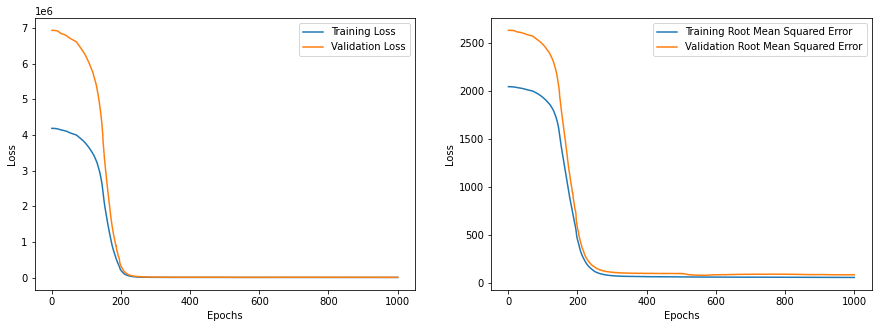

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of HUL

In [ ]:
HUL_prediction = HUL_Model.predict(HUL_Test_X)

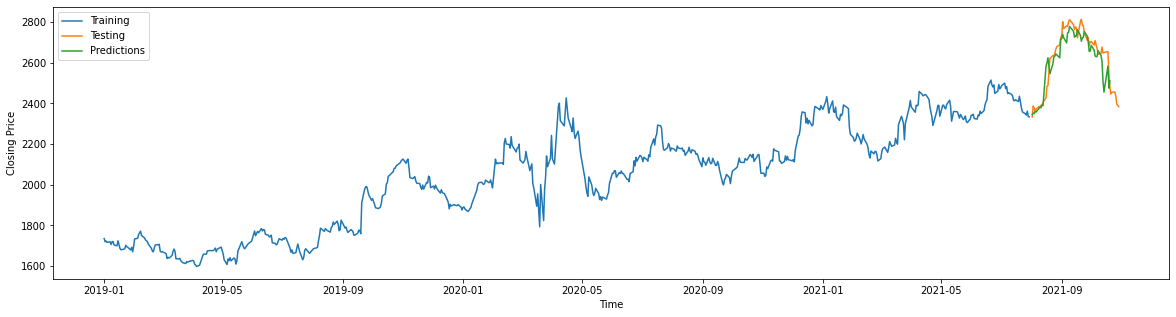

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(HUL['date'][HUL['date'] < '2021-08-01'], HUL['adj close'][HUL['date'] < '2021-08-01'], label = 'Training')
plt.plot(HUL['date'][HUL['date'] >= '2021-08-01'], HUL['adj close'][HUL['date'] >= '2021-08-01'], label = 'Testing')
plt.plot(HUL['date'][HUL['date'] >= '2021-08-01'][:-7], HUL_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [ ]:
rmse = math.sqrt(mean_squared_error(HUL_Test_Y.reshape(-1, 5), HUL_prediction))
mape = np.mean(np.abs(HUL_prediction - HUL_Test_Y.reshape(-1, 5))/np.abs(HUL_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 83.15527956263242
MAPE: 0.024783632333948483


#MARUTI

In [ ]:
MARUTI.tail()

,ticker,date,open,high,low,close,adj close,volume,Moving Average for 10 days,Moving Average for 20 days,Moving Average for 50 days,Daily Return
692,MARUTI.NS,2021-10-25,7355.0,7396.05,7219.65,7260.60,7260.60,247986.0,7552.180,7439.1900,7082.932,-0.020016
693,MARUTI.NS,2021-10-26,7265.0,7337.95,7210.20,7297.35,7297.35,292052.0,7511.835,7433.8850,7088.639,0.005062
694,MARUTI.NS,2021-10-27,7285.0,7461.25,7244.00,7356.25,7356.25,1217557.0,7478.080,7430.5050,7095.720,0.008071
695,MARUTI.NS,2021-10-28,7250.0,7529.70,7235.05,7369.70,7369.70,961188.0,7466.835,7429.7875,7106.577,0.001828
696,MARUTI.NS,2021-10-29,7350.0,7478.15,7294.85,7466.30,7466.30,179815.0,7463.775,7436.2000,7118.195,0.013108


In [ ]:
MARUTI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ticker                      697 non-null    object 
 1   date                        697 non-null    object 
 2   open                        697 non-null    float64
 3   high                        697 non-null    float64
 4   low                         697 non-null    float64
 5   close                       697 non-null    float64
 6   adj close                   697 non-null    float64
 7   volume                      697 non-null    float64
 8   Moving Average for 10 days  688 non-null    float64
 9   Moving Average for 20 days  678 non-null    float64
 10  Moving Average for 50 days  648 non-null    float64
 11  Daily Return                696 non-null    float64
dtypes: float64(10), object(2)
memory usage: 65.5+ KB


In [ ]:
# Change Dtype of date column
MARUTI["date"] = pd.to_datetime(MARUTI["date"])

###Split the Data into Training and Test set
    Training Period: 2019-01-01 - 2021-08-01

    Testing Period:  2021-08-01 - 2021-10-29

In [ ]:
MARUTI_date = '2021-08-01'
MARUTI_Train_X, MARUTI_Train_Y, MARUTI_Test_X, MARUTI_Test_Y = Dataset(MARUTI, MARUTI_date)

In [ ]:
MARUTI_Train_X.shape, MARUTI_Train_Y.shape, MARUTI_Test_X.shape, MARUTI_Test_Y.shape

((126, 5, 1), (126, 5, 1), (11, 5, 1), (11, 5, 1))

In [ ]:
# MARUTI['adj close'].tail(20)

In [ ]:
# MARUTI_Test_X[-1], MARUTI_Test_Y[-1]

### Model Fitting

In [ ]:
MARUTI_Model = Model()

In [ ]:
MARUTI_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
MARUTI_hist = MARUTI_Model.fit(MARUTI_Train_X, MARUTI_Train_Y, epochs = 1000, validation_data = (MARUTI_Test_X, MARUTI_Test_Y), callbacks=[callback])

Epoch 1/1000
4/4 [==============================] - 2s 142ms/step - loss: 43965968.0000 - root_mean_squared_error: 6630.6836 - val_loss: 49851332.0000 - val_root_mean_squared_error: 7060.5479
Epoch 2/1000
4/4 [==============================] - 0s 33ms/step - loss: 43965776.0000 - root_mean_squared_error: 6630.6694 - val_loss: 49851096.0000 - val_root_mean_squared_error: 7060.5308
Epoch 3/1000
4/4 [==============================] - 0s 35ms/step - loss: 43964944.0000 - root_mean_squared_error: 6630.6064 - val_loss: 49850636.0000 - val_root_mean_squared_error: 7060.4980
Epoch 4/1000
4/4 [==============================] - 0s 35ms/step - loss: 43963792.0000 - root_mean_squared_error: 6630.5190 - val_loss: 49849880.0000 - val_root_mean_squared_error: 7060.4448
Epoch 5/1000
4/4 [==============================] - 0s 35ms/step - loss: 43962672.0000 - root_mean_squared_error: 6630.4351 - val_loss: 49848424.0000 - val_root_mean_squared_error: 7060.3418
Epoch 6/1000
4/4 [==========================

In [ ]:
history_dict_MARUTI = MARUTI_hist.history

loss = history_dict_MARUTI["loss"]
root_mean_squared_error = history_dict_MARUTI["root_mean_squared_error"]
val_loss = history_dict_MARUTI["val_loss"]
val_root_mean_squared_error = history_dict_MARUTI["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

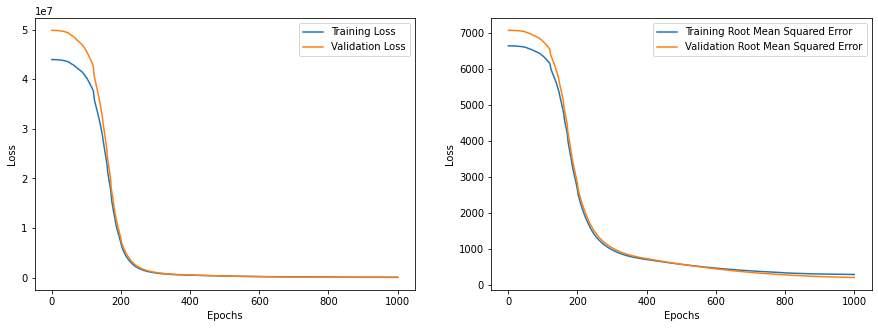

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Apple

In [ ]:
MARUTI_prediction = MARUTI_Model.predict(MARUTI_Test_X)

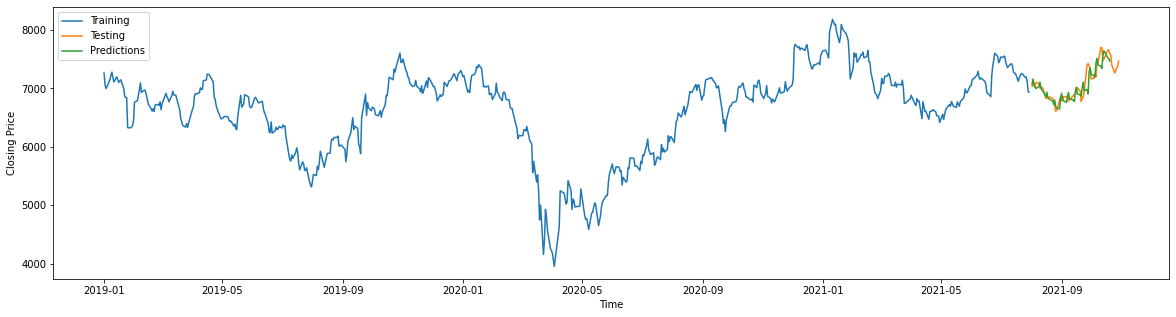

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(MARUTI['date'][MARUTI['date'] < '2021-08-01'], MARUTI['adj close'][MARUTI['date'] < '2021-08-01'], label = 'Training')
plt.plot(MARUTI['date'][MARUTI['date'] >= '2021-08-01'], MARUTI['adj close'][MARUTI['date'] >= '2021-08-01'], label = 'Testing')
plt.plot(MARUTI['date'][MARUTI['date'] >= '2021-08-01'][:-7], MARUTI_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [ ]:
rmse = math.sqrt(mean_squared_error(MARUTI_Test_Y.reshape(-1, 5), MARUTI_prediction))
mape = np.mean(np.abs(MARUTI_prediction - MARUTI_Test_Y.reshape(-1, 5))/np.abs(MARUTI_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 212.1413102439527
MAPE: 0.022748081276811966
